# 概要

* 計算物理学入門のP223～P230に掲載されているプログラム md をPythonで再現するためのファイル


In [1]:
import sys
import time
import matplotlib.pyplot as plt

In [2]:
# 変数の宣言

x = [0] * 16
y = [0] * 16
vx = [0] * 16
vy = [0] * 16
ax = [0] * 16
ay = [0] * 16

N = 0
Lx = 0
Ly = 0
dt = 0
dt2 = 0

gcum = []
for i in range(1000):
    gcum.append(i)
nbin = 0
dr = 0
xsave = [0] * 100
ysave = [0] * 100
R2cum = [0] * 100

# 変数の宣言２(グローバルで扱ったほうが良いものを追加している)
t = 0
ke = 0
kecum = 0
pecum = 0
vcum = 0
area = 0
pbc = 0

pe = 0
virial = 0

dx = 0
dy = 0
fx = 0
fy = 0
fxij = 0
fyij = 0
pot = 0

In [3]:
def initial():
    global pbc
    abc = 0
    global dt
    dt = 0.01
    global dt2
    dt= dt * dt
    
    response = ""
    global N
    N = 16
    global Lx
    Lx = 6
    global Ly
    Ly = 6
    
    DATA = [
        1.09,0.98,-0.33,0.78,3.12,5.25,0.12,-1.19
      , 0.08,2.38,-0.08,-0.10,0.54,4.08,-1.94,-0.56
      , 2.52,4.39,0.75,0.34,3.03,2.94,1.70,-1.08
      , 4.25,3.01,0.84,0.47,0.89,3.11,-1.04,0.06
      , 2.76,0.31,1.64,1.36,3.14,1.91,0.38,-1.24
      , 0.23,5.71,-1.58,0.55,1.91,2.46,-1.55,-0.16
      , 4.77,0.96,-0.23,-0.83,5.10,4.63,-0.31,0.65
      , 4.97,5.88,1.18,1.48,3.90,0.20,0.46,-0.51
    ]
    
    global x
    global y
    global vx
    global vy
    
    for i in range(N):
        x[i] = DATA[4*i+0]
        y[i] = DATA[4*i+1]
        vx[i] = DATA[4*i+2]
        vy[i] = DATA[4*i+3]
    
    global ke
    ke = 0
    for i in range(N):
        ke = ke + vx[i]* vx[i] + vy[i]* vy[i]
    ke = 0.5 * ke
    global area
    area = Lx * Ly
    global t
    t = 0
    global kecum
    kecum = 0
    global pecum
    pecum = 0
    global vcum
    vcum = 0    

In [4]:
def separation(ds, L):
    if (ds > 0.5 * L):
        return ds - L
    elif (ds < -0.5 * L):
        return ds + L
    else:
        return ds

In [5]:
def force():
    global dx
    global dy
    global fxij
    global fyij
    global pot
    r2 = dx*dx + dy*dy
    rm2 = 1/r2
    rm6 = rm2 * rm2 * rm2
    f_over_r = 24 * rm6 * (2 * rm6 - 1) * rm2
    fxij = f_over_r * dx
    fyij = f_over_r * dy
    pot = 4 * (rm6 * rm6 - rm6)

In [6]:
def accel():
    global pe
    pe = 0
    global virial
    virial = 0
    global N
    global x
    global y
    global Lx
    global Ly
    global ax
    global ay
    global dx
    global dy
    global pot
    for i in range(N-1):
        for j in range(i+1, N):
            dx = separation(x[i] - x[j], Lx)
            dy = separation(y[i] - y[j], Ly)
            force()
            ax[i] = ax[i] + fxij
            ay[i] = ay[i] + fyij
            ax[j] = ax[j] - fxij
            ay[j] = ay[j] - fyij
            pe = pe + pot
            virial = virial + dx*fxij + dy*fyij
            

In [7]:
def pbc(pos, L):
    if (pos < L):
        return (pos+L)
    elif(pos > L):
        return (pos-L)
    else:
        return (pos)
    

In [8]:
def Verlet():
    global x
    global y
    global vx
    global vy
    global ax
    global ay
    global N
    global Lx
    global Ly
    global dt
    global dt2
    global ke
    global t
    
    for i in range(N):
        xnew = x[i] + vx[i] * dt + 0.5 * ax[i] * dt2
        ynew = y[i] + vy[i] * dt + 0.5 * ay[i] * dt2
        vx[i] = vx[i] + 0.5 * ax[i] * dt
        vy[i] = vy[i] + 0.5 * ay[i] * dt
        x[i] = pbc(xnew, Lx)
        y[i] = pbc(ynew, Ly)
        
    accel()
        
    ke = 0
    for i in range(N):
        vx[i] = vx[i] + 0.5 * ax[i] * dt
        vy[i] = vy[i] + 0.5 * ay[i] * dt
        ke = ke + vx[i] * vx[i] + vy[i] * vy[i]
        ke = 0.5 * ke
        t = t + 1

In [9]:
def show_output():
    global t
    global ke
    global pe
    global virial
    global kecum
    global vcum
    global ncum
    global area
    global N
    global Lx
    global Ly

    print_str = ""
    print_str += "ncum:"+str(ncum)
    print_str += ", t:"+str(t)
    E = ke + pe
    print_str += ", E:"+'{:.3E}'.format(E)
    kecum = kecum + ke
    vcum = vcum + virial
    mean_ke = kecum / ncum
    p = mean_ke + (0.5 * vcum) / ncum
    p = p / area
    print_str += ", mean_ke/N:"+'{:.3E}'.format(mean_ke/N)
    print_str += ", p:"+'{:.3E}'.format(p)
    
    print_str += ", ke:"+'{:.3E}'.format(ke)
    print_str += ", pe:"+'{:.3E}'.format(pe)
    print_str += ", sum(vx):"+'{:.5E}'.format(sum(vx))
    print_str += ", sum(vy):"+'{:.5E}'.format(sum(vy))
    print_str += ", sum(ax):"+'{:.5E}'.format(sum(ax))
    print_str += ", sum(ay):"+'{:.5E}'.format(sum(ay))
    
    print(print_str)
    


ncum:10000, t:160000, E:7.833E+26, mean_ke/N:4.896E+21, p:2.176E+21, ke:7.833E+26, pe:-2.934E-42, sum(vx):-8.53951E+01, sum(vy):-2.13580E+01, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:20000, t:320000, E:3.286E+27, mean_ke/N:1.272E+22, p:5.652E+21, ke:3.286E+27, pe:-5.187E-46, sum(vx):1.02630E+03, sum(vy):-2.99601E+02, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:30000, t:480000, E:7.511E+27, mean_ke/N:2.413E+22, p:1.072E+22, ke:7.511E+27, pe:-3.596E-48, sum(vx):3.41257E+03, sum(vy):-5.77949E+02, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:40000, t:640000, E:1.346E+28, mean_ke/N:3.912E+22, p:1.739E+22, ke:1.346E+28, pe:-1.081E-49, sum(vx):5.79847E+03, sum(vy):-8.55823E+02, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:50000, t:800000, E:2.112E+28, mean_ke/N:5.770E+22, p:2.564E+22, ke:2.112E+28, pe:-7.195E-51, sum(vx):8.18462E+03, sum(vy):-1.13409E+03, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:60000, t:960000, E:3.051E+28, mean_ke/N:7.987E+22, p:3.550E+22, ke:3.051E+28, p

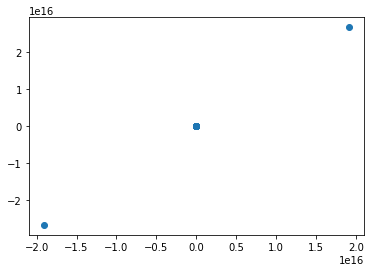

ncum:110000, t:1760000, E:1.033E+29, mean_ke/N:2.445E+23, p:1.087E+23, ke:1.033E+29, pe:-5.224E-55, sum(vx):-2.99719E+03, sum(vy):2.30151E+04, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:120000, t:1920000, E:1.230E+29, mean_ke/N:2.882E+23, p:1.281E+23, ke:1.230E+29, pe:-1.830E-55, sum(vx):-3.17253E+03, sum(vy):3.27361E+04, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:130000, t:2080000, E:1.444E+29, mean_ke/N:3.355E+23, p:1.491E+23, ke:1.444E+29, pe:-6.975E-56, sum(vx):4.21363E+03, sum(vy):4.24604E+04, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:140000, t:2240000, E:1.676E+29, mean_ke/N:3.863E+23, p:1.717E+23, ke:1.676E+29, pe:-2.857E-56, sum(vx):1.15998E+04, sum(vy):5.21847E+04, sum(ax):-7.04288E-03, sum(ay):4.56543E-02
ncum:150000, t:2400000, E:1.925E+29, mean_ke/N:4.408E+23, p:1.959E+23, ke:1.925E+29, pe:-1.245E-56, sum(vx):1.89858E+04, sum(vy):6.19080E+04, sum(ax):-7.04288E-03, sum(ay):4.56543E-02


KeyboardInterrupt: 

In [10]:
initial()
accel()
E = ke + pe
ncum = 0
flag = True
while (flag):
#     show_positions(flag)
    Verlet()
    ncum = ncum + 1
    if(ncum % 10000 == 0):
        show_output()
    if(ncum % 100000 == 0):
        plt.scatter(x, y)
        print(f"x:{x}")
        print(f"y:{y}")
#         print(f"vx:{vx}")
#         print(f"vy:{vy}")
        plt.show()
        

save_config()